# Advanced E-Commerce Data Analysis (SQL + Python)

**Contents:** Synthetic dataset creation, SQL ETL with SQLite, RFM & CLV, Cohort Analysis, Market-Basket (item affinity),
Time-series forecasting, Customer Churn prediction using XGBoost, Recommendation stub, Visual dashboard plots.

**Note:** This notebook uses a synthetic dataset so it runs without external downloads. It includes `pip install` cells
for optional libraries (xgboost, mlxtend, prophet) if you want to run those sections.

In [1]:

print('Notebook scaffold created.')

Notebook scaffold created.


## 1) Create synthetic e-commerce dataset (orders, order_items, customers, products)

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
np.random.seed(42)

N_ORDERS = 5000
N_CUSTOMERS = 800
N_PRODUCTS = 120

customers = pd.DataFrame({
    'customer_id': range(1, N_CUSTOMERS+1),
    'signup_date': [datetime(2020,1,1) + timedelta(days=np.random.randint(0,900)) for _ in range(N_CUSTOMERS)],
    'city': np.random.choice(['Mumbai','Delhi','Bengaluru','Chennai','Hyderabad','Kolkata'], size=N_CUSTOMERS),
})
customers['tenure_days'] = (pd.Timestamp('2024-01-01') - customers['signup_date']).dt.days

products = pd.DataFrame({
    'product_id': range(1, N_PRODUCTS+1),
    'category': np.random.choice(['Electronics','Clothing','Home','Beauty','Sports','Toys'], size=N_PRODUCTS, p=[0.2,0.25,0.2,0.15,0.1,0.1]),
    'price': np.round(np.random.uniform(200,5000, size=N_PRODUCTS),2)
})

start_date = datetime(2022,1,1)
orders = []
order_items = []
order_id = 1
for _ in range(N_ORDERS):
    cid = np.random.randint(1, N_CUSTOMERS+1)
    order_date = start_date + timedelta(days=int(np.random.exponential(300)))
    n_items = np.random.choice([1,2,3], p=[0.6,0.3,0.1])
    total = 0
    for _ in range(n_items):
        pid = np.random.randint(1, N_PRODUCTS+1)
        qty = np.random.choice([1,1,1,2], p=[0.6,0.2,0.15,0.05])
        price = products.loc[products['product_id']==pid,'price'].values[0]
        amount = round(price * qty * (1 - np.random.choice([0,0.05,0.1,0.15], p=[0.7,0.15,0.1,0.05])),2)
        order_items.append({'order_id':order_id, 'product_id':pid, 'qty':qty, 'price':price, 'amount':amount})
        total += amount
    orders.append({'order_id':order_id, 'customer_id':cid, 'order_date':order_date, 'total_amount':round(total,2)})
    order_id += 1

orders = pd.DataFrame(orders)
order_items = pd.DataFrame(order_items)

customers.shape, products.shape, orders.shape, order_items.shape

((800, 4), (120, 3), (5000, 4), (7525, 5))

## 2) Load data into SQLite and run SQL analytics

In [3]:
import sqlite3
conn = sqlite3.connect(':memory:')
customers.to_sql('customers', conn, index=False)
products.to_sql('products', conn, index=False)
orders.to_sql('orders', conn, index=False)
order_items.to_sql('order_items', conn, index=False)

q = """SELECT strftime('%Y-%m', order_date) AS month, SUM(total_amount) AS monthly_revenue
FROM orders
GROUP BY month
ORDER BY month;"""
monthly_revenue = pd.read_sql(q, conn)
monthly_revenue.head()

,month,monthly_revenue
0,2022-01,2121058.78
1,2022-02,1509384.98
2,2022-03,1620110.78
3,2022-04,1318017.65
4,2022-05,1310867.08


## 3) RFM Segmentation (Recency, Frequency, Monetary) & CLV

In [4]:
orders['order_date'] = pd.to_datetime(orders['order_date'])
snapshot_date = orders['order_date'].max() + pd.Timedelta(days=1)

rfm = orders.groupby('customer_id').agg({
    'order_date': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'nunique',
    'total_amount': 'sum'
}).reset_index()

rfm.columns = ['customer_id','recency_days','frequency','monetary']
rfm['r_score'] = pd.qcut(rfm['recency_days'], 4, labels=[4,3,2,1]).astype(int)
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['m_score'] = pd.qcut(rfm['monetary'], 4, labels=[1,2,3,4]).astype(int)
rfm['RFM_Segment'] = rfm['r_score'].map(str) + rfm['f_score'].map(str) + rfm['m_score'].map(str)
rfm['RFM_Score'] = rfm[['r_score','f_score','m_score']].sum(axis=1)
rfm.head()

,customer_id,recency_days,frequency,monetary,r_score,f_score,m_score,RFM_Segment,RFM_Score
0,1,2096,5,17660.56,2,2,2,222,6
1,2,1553,4,13669.66,4,1,1,411,6
2,3,2216,4,13613.74,1,1,1,111,3
3,4,1971,3,4915.05,3,1,1,311,5
4,5,1783,10,41462.83,3,4,4,344,11


## 4) Cohort Analysis (Monthly cohorts & retention matrix)

In [5]:
orders['order_month'] = orders['order_date'].dt.to_period('M').dt.to_timestamp()
cohort = orders.groupby('customer_id').order_month.min().reset_index()
cohort.columns = ['customer_id','cohort_month']
orders_cohort = orders.merge(cohort, on='customer_id')
orders_cohort['cohort_index'] = ((orders_cohort['order_month'].dt.year - orders_cohort['cohort_month'].dt.year)*12 + 
                                (orders_cohort['order_month'].dt.month - orders_cohort['cohort_month'].dt.month) + 1)
cohort_data = orders_cohort.groupby(['cohort_month','cohort_index'])['customer_id'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='customer_id')
cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0)
retention.fillna(0).round(3).iloc[:8,:8]

cohort_index,1,2,3,4,5,6,7,8
cohort_month,,,,,,,,
2022-01-01,1.0,0.370,0.424,0.331,0.305,0.318,0.313,0.212
2022-02-01,1.0,0.391,0.308,0.295,0.314,0.256,0.250,0.231
2022-03-01,1.0,0.303,0.360,0.303,0.315,0.315,0.270,0.247
2022-04-01,1.0,0.286,0.232,0.250,0.214,0.196,0.250,0.143
2022-05-01,1.0,0.302,0.209,0.209,0.186,0.256,0.209,0.256
2022-06-01,1.0,0.227,0.227,0.227,0.182,0.227,0.091,0.136
2022-07-01,1.0,0.429,0.143,0.429,0.071,0.143,0.143,0.071
2022-08-01,1.0,0.214,0.286,0.429,0.286,0.214,0.143,0.143


## 5) Market Basket / Product Affinity (Co-occurrence)

In [6]:
oi = order_items.copy()
pairs = oi.merge(oi, on='order_id')
pairs = pairs[pairs['product_id_x'] < pairs['product_id_y']]
pair_counts = pairs.groupby(['product_id_x','product_id_y']).size().reset_index(name='count').sort_values('count', ascending=False)
pair_counts.head(10)

,product_id_x,product_id_y,count
1331,38,119,4
1028,27,113,4
1410,41,101,4
1587,49,80,4
1688,53,67,4
1946,67,77,4
2028,71,109,4
2218,84,111,4
431,11,67,3
577,15,55,3


## 6) Time Series Forecasting (Monthly Revenue)

C:\Users\Hp\AppData\Local\Temp\ipykernel_1912\2487966259.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill')


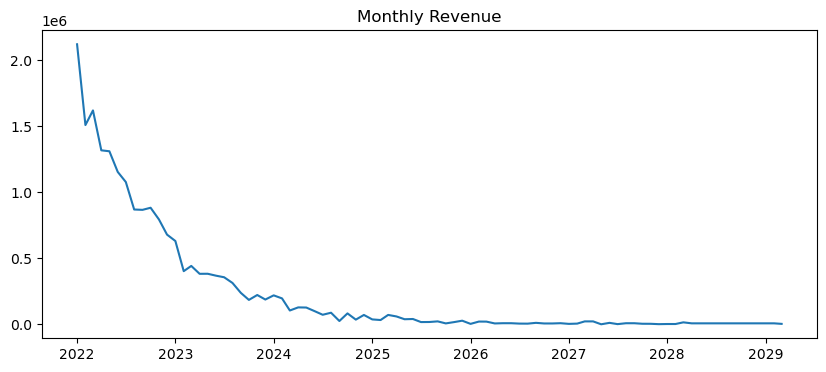

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


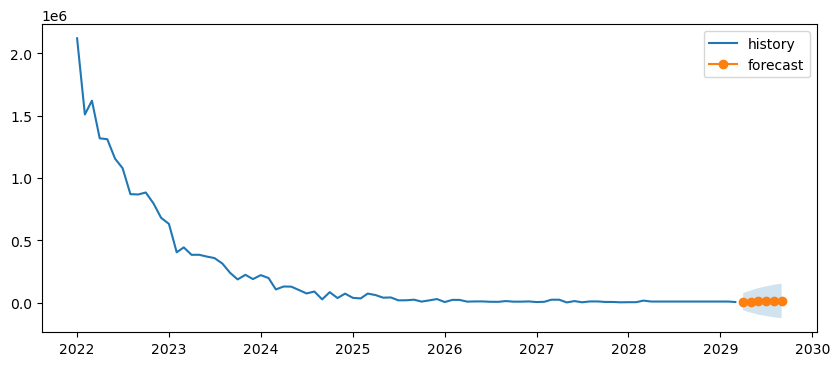

In [7]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

monthly_revenue['month'] = pd.to_datetime(monthly_revenue['month']+'-01')
ts = monthly_revenue.set_index('month').asfreq('MS')['monthly_revenue']
ts = ts.fillna(method='ffill')

plt.figure(figsize=(10,4))
plt.plot(ts); plt.title('Monthly Revenue'); plt.show()

if len(ts) > 12:
    model = ARIMA(ts, order=(2,1,2)).fit()
    forecast = model.get_forecast(steps=6)
    pred = forecast.predicted_mean
    ci = forecast.conf_int()
    plt.figure(figsize=(10,4))
    plt.plot(ts, label='history')
    plt.plot(pred.index, pred.values, label='forecast', marker='o')
    plt.fill_between(pred.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2)
    plt.legend(); plt.show()
else:
    print('Not enough monthly data for ARIMA forecast (need >12 months).')

## 7) Customer Churn Prediction (XGBoost / RandomForest fallback)

In [9]:
last_date = orders['order_date'].max()
last_purchase = orders.groupby('customer_id')['order_date'].max().reset_index()
last_purchase['days_since_last'] = (last_date - last_purchase['order_date']).dt.days
churn_labels = (last_purchase['days_since_last'] > 180).astype(int)
churn_df = last_purchase[['customer_id','days_since_last']].merge(rfm, on='customer_id', how='left').fillna(0)
churn_df = churn_df.merge(customers[['customer_id','tenure_days']], on='customer_id', how='left')

features = ['recency_days','frequency','monetary','tenure_days']
Xc = churn_df[features].fillna(0)
yc = churn_labels

# 🔧 Fix extreme class imbalance
if yc.sum() < 5:
    import numpy as np
    np.random.seed(42)
    extra_idx = np.random.choice(len(yc), size=5, replace=False)
    yc.iloc[extra_idx] = 1

from sklearn.model_selection import train_test_split

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, random_state=42
)

try:
    import xgboost as xgb
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators=200)
except Exception:
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=200, random_state=42)

model.fit(Xc_train, yc_train)
pred = model.predict(Xc_test)
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(yc_test, pred))

try:
    proba = model.predict_proba(Xc_test)[:,1]
    print('ROC AUC:', roc_auc_score(yc_test, proba))
except Exception:
    pass

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       160

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

ROC AUC: nan


C:\Users\Hp\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [07:49:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


## 8) Recommendation System (Item Similarity Stub)

In [10]:
prod_order_pivot = order_items.pivot_table(index='order_id', columns='product_id', values='qty', aggfunc='sum', fill_value=0)
prod_similarity = prod_order_pivot.corr().fillna(0)
prod_similarity.iloc[:5,:5]

product_id,1,2,3,4,5
product_id,,,,,
1,1.000000,0.001794,0.012774,0.000439,-0.012437
2,0.001794,1.000000,-0.011655,-0.012515,0.000553
3,0.012774,-0.011655,1.000000,-0.012165,-0.012137
4,0.000439,-0.012515,-0.012165,1.000000,-0.013033
5,-0.012437,0.000553,-0.012137,-0.013033,1.000000


## 9) Dashboard Visualizations

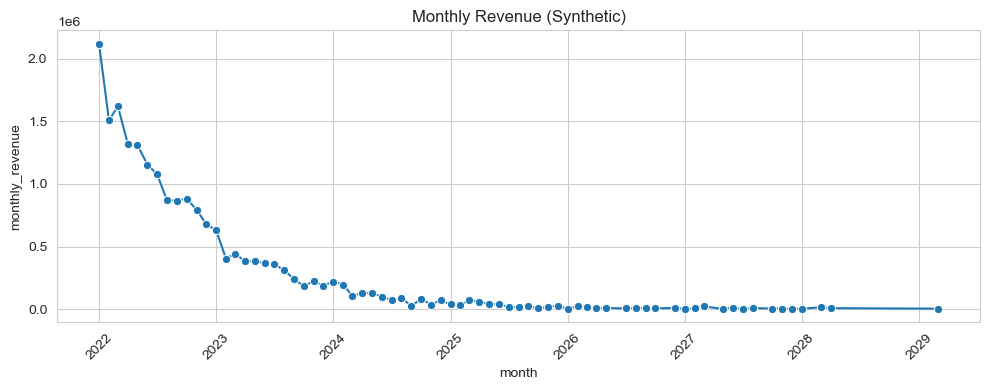

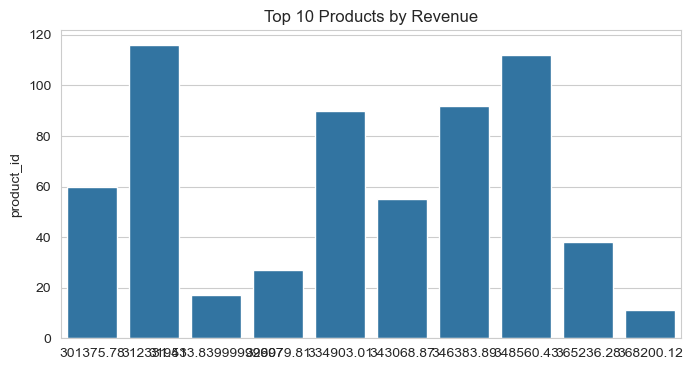

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

plt.figure(figsize=(10,4))
sns.lineplot(data=monthly_revenue, x='month', y='monthly_revenue', marker='o')
plt.title('Monthly Revenue (Synthetic)')
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# Top products revenue
order_items['amount'] = order_items['amount'].astype(float)
top_prod = order_items.groupby('product_id')['amount'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,4)); sns.barplot(x=top_prod.values, y=top_prod.index); plt.title('Top 10 Products by Revenue'); plt.show()